In [12]:
#@ Downloading necessaries dependencies and libraries:
!pip install -U d2l # -u flag for Upgrade to latest version
from d2l import torch as d2l
import os
import torch
from torch import nn
from IPython import display

#### Using **Large Movie Review Dataset** where the dataset is divided into training and testing and each contains 25000 movie reviews.

In [13]:
#@ Getting dataset:
batch_size=32
train_iter, test_iter, vocab=d2l.load_data_imdb(batch_size)

In [20]:
#@ RNN Model:
class BiRNN(nn.Module):
  def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
    super(BiRNN, self).__init__(**kwargs)
    self.embedding=nn.Embedding(vocab_size, embed_size)
    self.encoder=nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
    self.decoder=nn.Linear(4*num_hiddens, 2)

  def forward(self, inputs):                                                  # Forward Propagation Function.
    embeddings = self.embedding(inputs.T)                                     # Implementation of Embedding Layer.
    self.encoder.flatten_parameters()
    outputs, _ = self.encoder(embeddings)                                     # Implementation of LSTM.
    encoding = torch.cat((outputs[0], outputs[-1]), dim=1)                    # Concatenating Initial and Final Timestep.
    outs = self.decoder(encoding)                                             # Implementation of Linear Layer.
    return outs

In [21]:
embed_size, num_hiddens=100, 100
num_layers, devices=2, d2l.try_all_gpus()
net=BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [22]:
#@ Initializing weights:
def init_weights(m):
  if type(m)==nn.Linear:
    nn.init.xavier_uniform_(m.weight)
  if type(m)==nn.LSTM:
    for param in m._flat_weights_names:
      if 'weight' in param:
        nn.init.xavier_uniform_(m._parameters[param])
net.apply(init_weights);

In [23]:
#@ Loading Pretrained Word Vectors:
glove_embedding = d2l.TokenEmbedding("glove.6b.100d")
embeds=glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds)
net.embedding.weight.requires_grad=False

loss 0.332, train acc 0.857, test acc 0.840
1259.7 examples/sec on [device(type='cuda', index=0)]


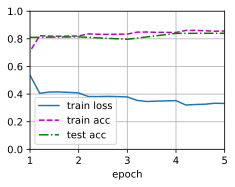

In [24]:
#@ Training model:
lr, num_epochs=0.01, 5
trainer=torch.optim.Adam(net.parameters(), lr=lr)
loss=nn.CrossEntropyLoss(reduction='none')
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [36]:
#@ Model evaluation:
def predict_sentiment(net, vocab, sentence):
  sentence=torch.tensor(vocab[sentence.split()], device=d2l.try_gpu())
  label=torch.argmax(net(sentence.reshape(1, -1)), dim=1)
  return "positive"if label==1 else "negative"


predict_sentiment(net, vocab, 'this movie was okay')


'negative'

In [35]:


predict_sentiment(net, vocab, 'this movie was wild')

'positive'